<a href="https://colab.research.google.com/github/yvesivan/Final-Exam-Model-Deployment-in-the-Cloud_Group-10/blob/main/Model_CPE019_Group_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


| <h1> Final Exam </h1> | <h1> Model Deployment in the Cloud </h1> |
|--- | --- |
***Name/s:** Yves Ivan Borganio
Vargas, Leo Glenn
**Course and Section:** CPE 019-CPE32S1
**Instructor:** Engr. Ryan Francisco
**Date Performed:** May 16, 2024
**Date Submitted:** May 18, 2024
**Group No.:** 10

<hr>

**Instructions**:

*   You can choose any previous deep learning model.
*   Follow the instructions on deploying a model using Streamlit App in the cloud.

**Objectives:**
This activity aims to apply all the learnings for the Final Period.

<hr>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os #Its main purpose is to perform operations related to file and directory manipulation.
import shutil # This module aids in the automation of the copying and deleting of files and folders.
import random #Provides functions for generating random numbers.

# **Prepare the Dataset (EDA)**

In [ ]:
# We first define the paths of our datasets. We used google drive as our cloud storage
source_folder = '/content/drive/MyDrive/SISKO/Multi-class Weather Dataset'  # this folder has the multi-class weather dataset
training_folder = '/content/drive/MyDrive/SISKO/Training'  # this is only a folder without files, and will be storage for our splitted training files later.
validation_folder = '/content/drive/MyDrive/SISKO/Validation'  # this is only a folder without files, and will be storage for our splitted validation files later.

# Define classes
classes = ['Cloudy', 'Rain', 'Shine', 'Sunrise'] # These are the classes in the datasets, so we have four classes and we put it

# We define the ratio of data to put into training and validation sets
train_ratio = 0.8  # 80% for training and 20% for validation

# Iterate through each class folder
for cls in classes: #This loop iterates through each class in the classes list to make it more organized.
    class_folder = os.path.join(source_folder, cls) # We go to the the path to the folder corresponding to the current class (cls) by joining the source_folder (root dataset folder) and the class name (cls).
    images = os.listdir(class_folder) # Retrieves a list of filenames (images) within the current class folder (class_folder).
    random.shuffle(images) # We shuffled the images to prevent any inherent order or patterns in the data from affecting the learning process.

    print(f"Class: {cls}, Total Images: {len(images)}") #We print the type of class and the detected total of images

    # Calculate split indices based on train_ratio
    split_idx = int(len(images) * train_ratio) #The dataset should be split into training and validation sets based on the specified train_ratio

    # Move images to training folder
    for image in images[:split_idx]:
        src = os.path.join(class_folder, image)
        dst = os.path.join(training_folder, cls, image)
        if not os.path.exists(os.path.join(training_folder, cls)):
            os.makedirs(os.path.join(training_folder, cls))
        shutil.copy2(src, dst)  # Copy without moving because in google drive, we found out that after transferring the images to training and validation folder, the images in the source is gone and if an error occur We will import again the files which is time consuming

    # Move images to validation folder
    for image in images[split_idx:]:
        src = os.path.join(class_folder, image)
        dst = os.path.join(validation_folder, cls, image)
        if not os.path.exists(os.path.join(validation_folder, cls)):
            os.makedirs(os.path.join(validation_folder, cls))
        shutil.copy2(src, dst)  # same case in the training folder

print("Dataset split into training and validation sets successfully.") # 1. Prepare the Dataset (EDA)


Class: Cloudy, Total Images: 300
Class: Rain, Total Images: 215
Class: Shine, Total Images: 253
Class: Sunrise, Total Images: 364
Dataset split into training and validation sets successfully.


In [ ]:
import matplotlib.pyplot as plt # A helpful plotting library because it easy to plot and has good visualization of dataset we have.


#**Create a Baseline MLP Classification Model**

In [ ]:
import tensorflow as tf # Provides tools for building and training machine learning models, including deep learning models. we define it as tf so it can be easy to call.
from tensorflow.keras.preprocessing.image import ImageDataGenerator # We can leverage TensorFlow and its Keras API to build, train, and evaluate deep learning models, particularly for tasks involving image data.
from tensorflow.keras.callbacks import EarlyStopping # It can help prevent overfitting by stopping training early if the model's performance on a validation dataset starts to degrade.

In [ ]:
# We define data generators for training and validation with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, # Pixel values are rescaled to fall between [0, 1].
    rotation_range=20, # Rotate pictures at random between -20 and +20 degrees
    width_shift_range=0.2, # Images can be arbitrarily shifted horizontally by up to 20% of their overall width.
    height_shift_range=0.2, # Images can be arbitrarily shifted vertically by up to 20% of their overall height.
    shear_range=0.2, # Use shear transformations with a 20-degree maximum shear angle.
    zoom_range=0.2, # Zoom in on pictures at random up to 20%
    horizontal_flip=True,  # Flip pictures horizontally at random
    fill_mode='nearest' # Method for filling in recently formed pixels following transformations
)

validation_datagen = ImageDataGenerator(rescale=1./255) # Pixel values are rescaled to fall between [0, 1].

# We set the batch size as we prefer
batch_size = 32

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/SISKO/Training',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/SISKO/Validation',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Define CNN model
model = tf.keras.models.Sequential([
     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

Found 1120 images belonging to 4 classes.
Found 543 images belonging to 4 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                       

# **Train the model**

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with EarlyStopping callback and verbose=1
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size, # Number of steps per epoch
    epochs=13, # Number of epochs for training
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size, # Number of steps per epoch
    callbacks=[early_stopping],  # Include EarlyStopping callback
    verbose=1  # Display training progress
)

Epoch 1/13
35/35 [==============================] - 202s 6s/step - loss: 0.8118 - accuracy: 0.6491 - val_loss: 0.7249 - val_accuracy: 0.7266
Epoch 2/13
35/35 [==============================] - 77s 2s/step - loss: 0.5837 - accuracy: 0.7884 - val_loss: 0.5506 - val_accuracy: 0.7969
Epoch 3/13
35/35 [==============================] - 74s 2s/step - loss: 0.5076 - accuracy: 0.8071 - val_loss: 0.4415 - val_accuracy: 0.8340
Epoch 4/13
35/35 [==============================] - 77s 2s/step - loss: 0.4366 - accuracy: 0.8438 - val_loss: 0.3738 - val_accuracy: 0.8652
Epoch 5/13
35/35 [==============================] - 83s 2s/step - loss: 0.3912 - accuracy: 0.8598 - val_loss: 0.4601 - val_accuracy: 0.8535
Epoch 6/13
35/35 [==============================] - 81s 2s/step - loss: 0.3782 - accuracy: 0.8625 - val_loss: 0.2903 - val_accuracy: 0.9023
Epoch 7/13
35/35 [==============================] - 73s 2s/step - loss: 0.3410 - accuracy: 0.8786 - val_loss: 0.2301 - val_accuracy: 0.9023
Epoch 8/13
35/35 [=

# **Evaluate the model**

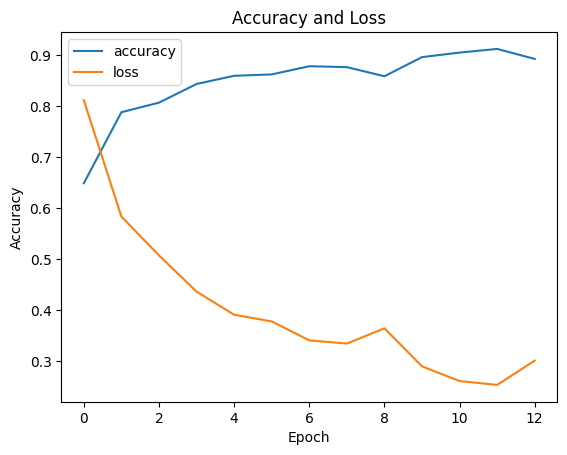

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.title('Accuracy and Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['accuracy', 'loss'], loc='upper left')
    plt.show()


# Call the function to plot the training history
plot_history(history)

In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


13/13 [==============================] - 9s 709ms/step - loss: 0.2716 - accuracy: 0.9064
Validation Loss: 0.27158787846565247
Validation Accuracy: 0.9064039587974548


The adjustments that we did is we lower the epoch because we observed in the last midterm exam, the progress of the training of the model was stopping early due to the EarlyStopping callback with a patience of 5. That is why we selected our optimized value of epoch resulting a satisfied accuracy of 90

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/Group 10 Models/Weather_Classification-Model.h5')

This is the code in saving the model in .h5 file

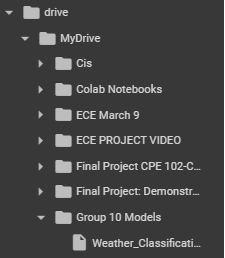